In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.opflow import PauliSumOp, AbelianGrouper
from qiskit.circuit.library import EfficientSU2

from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.algorithms.optimizers import SPSA

from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeBurlington
from qiskit import transpile, QuantumCircuit

from qiskit.providers.ibmq import IBMQ

import mthree

In [2]:
# load account
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
# provider = IBMQ.get_provider(hub='ibm-q-internal', group='near-time')
provider = IBMQ.get_provider(hub='ibm-q', group='open')

In [4]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [5]:
# define backends
ibmq_qasm_backend = provider.get_backend('ibmq_qasm_simulator')
qasm_backend = QasmSimulator(shots=8192)
noisy_backend = FakeBurlington()
real_backend = provider.get_backend('ibmq_lima')

In [6]:
# select backend
backend = qasm_backend
# backend = noisy_backend
# backend = real_backend

# set number of shots
backend.shots = 8192

# 0. Circuit Sampling

In [7]:
def raw_sample(circuit, backend=backend, optimization_level=3):
    
    # transpile circuit
    qc = transpile(circuit, backend, optimization_level=optimization_level)
    
    # run circuit
    job = backend.run(qc)
    counts = job.result().get_counts()
    
    # evaluate probabilities
    shots = sum(counts.values())
    probabilities = {b: c/shots for b, c in counts.items()}
    return probabilities
    

# instantiate and calibrate mitigation scheme
mit = mthree.M3Mitigation(backend)
mit.cals_from_system()
# mit.cals_from_system(method='independent')  # use this to speed up noisy simulation
    
def mitigated_sample(circuit, backend=backend, mit=mit, optimization_level=3):
    
    # transpile circuit
    qc = transpile(circuit, backend, optimization_level=optimization_level)
    
    # determine final qubit mappings
    maps = mthree.utils.final_measurement_mapping(qc)
    
    # run circuit
    job = backend.run(qc)
    counts = job.result().get_counts()
        
    # mitigate shots
    quasi_probabilities = mit.apply_correction(counts, maps)    
    return quasi_probabilities

# choose sampling function
sample = raw_sample
# sample = mitigated_sample

In [8]:
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1, 2)
circuit.measure_all()
circuit.draw()

┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────────░─┤M├──────
        └───┘┌─┴─┐      ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──■───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2

In [9]:
# raw sampling without noise
raw_sample(circuit, qasm_backend)

{'111': 0.497314453125, '000': 0.502685546875}

In [10]:
# raw sampling with noise
raw_sample(circuit, backend)

{'000': 0.5047607421875, '111': 0.4952392578125}

In [11]:
# mitigating sampling with noise
mitigated_sample(circuit, backend)

{'000': 0.5, '111': 0.5}

# 1. Estimation of Expectation Values and VQE

### 1.1 Preliminaries
- `PauliSumOp`
- `AbelianGrouper`
- Deriving measurement bases

In [12]:
# define Hamiltonian
H = PauliSumOp.from_list([('XXI', 1), ('XII', 2), ('YIY', 3), ('ZZI', 4), ('XIY', 5)])

# second test Hamiltonian
# H = PauliSumOp.from_list([('ZZI', 1), ('ZII', 2), ('ZIZ', 3), ('IZZ', 4)])

print(H)

1.0 * XXI
+ 2.0 * XII
+ 3.0 * YIY
+ 4.0 * ZZI
+ 5.0 * XIY


In [13]:
# group commuting Pauli terms 
grouper = AbelianGrouper()
groups = grouper.convert(H)
print('-----------')
for group in groups.oplist:
    print(group)
    print('-----------')

-----------
3.0 * YIY
-----------
4.0 * ZZI
-----------
1.0 * XXI
+ 2.0 * XII
+ 5.0 * XIY
-----------


In [14]:
# derives measurement basis from group of commuting Pauli terms
for group in groups:
    basis = ['I']*group.num_qubits
    for pauli_string in group.primitive.paulis:
        for i, pauli in enumerate(pauli_string):
            p = str(pauli)
            if p != 'I':
                if basis[i] == 'I':
                    basis[i] = p
                elif basis[i] != p:
                    raise ValueError('PauliSumOp contains non-commuting terms!')
    print(basis)

['Y', 'I', 'Y']
['I', 'Z', 'Z']
['Y', 'X', 'X']


### 1.2 Estimator class

In [15]:
class Estimator():
    
    def __init__(self, observable, circuit, callback=None):
        """ Instantiate estimator for given observable and circuit. """
        
        # store problem
        self._observable = observable
        self._circuit = circuit
        
        # group Pauli terms
        self._grouper = AbelianGrouper()
        self._groups = self._grouper.convert(self._observable).oplist
        
        # derive measurement bases
        self._bases = []
        for group in self._groups:
            self._bases += [self._get_measurement_basis(group)]
            
        # construct circuits with post-rotations
        self._circuits = []
        for basis in self._bases:
            self._circuits += [self._append_post_rotation(self._circuit, basis)]
            
        # store callback
        self._callback = callback
        
    def _get_measurement_basis(self, observable):
        """ Derive measurement basis from observable or raise exception in case of non-commuting terms. """
                
        basis = ['I']*observable.num_qubits
        for pauli_string in observable.primitive.paulis:
            for i, pauli in enumerate(pauli_string):
                p = str(pauli)
                if p != 'I':
                    if basis[i] == 'I':
                        basis[i] = p
                    elif basis[i] != p:
                        raise ValueError('PauliSumOp contains non-commuting terms!')
        return basis
    
    def _append_post_rotation(self, circuit, basis):
        """ Append post rotation to circuit to measure in given basis. """
        
        new_circuit = circuit.copy()
        for i, pauli in enumerate(basis):
            if pauli == 'X':  # H @ X @ H = Z
                new_circuit.h(i)
            if pauli == 'Y':  # S^dag @ H @ Y @ H @ S = Z
                new_circuit.s(i)
                new_circuit.h(i)
        new_circuit.measure_all()
        return new_circuit
    
    def estimate(self, param_values=None):
        """ Estimate expectation value of given observable in state corresponding to given parameter values. """

        if param_values is None and self._circuit.num_parameters > 0 or\
            len(param_values) != self._circuit.num_parameters:
            raise ValueError('Wrong number of parameters!')
        
        value = 0        
        for group, circuit in zip(self._groups, self._circuits):
            value += self._estimate_group(group, circuit, param_values)        
            
        if self._callback:
            self._callback(np.real(value))
            
        return np.real(value)
        
    def _estimate_group(self, group, circuit, param_values):
        """ Estimate expectation value for group of commuting terms that can be measured in the same basis. """
        
        probabilities = sample(circuit.bind_parameters(param_values), backend)
        
        value = 0
        for (pauli, coeff) in zip(group.primitive.paulis, group.primitive.coeffs):
            val = 0
            p = str(pauli)
            for b, prob in probabilities.items():
                val += prob * np.prod([(-1)**(b[i] == '1' and p[i] != 'I') for i in range(len(b))])

            value += coeff * val
    
        return value

In [16]:
# define parametrized circuit
circuit = EfficientSU2(H.num_qubits, entanglement='linear', reps=1)
circuit.decompose().draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐             
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├─────────────
     ├──────────┤├──────────┤┌─┴─┐└──────────┘├──────────┤┌───────────┐
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├─────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤└───┘   ┌─┴─┐    ├──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├────────┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
     └──────────┘└──────────┘        └───┘    └──────────┘└───────────┘

In [17]:
# instantiate estimator
estimator = Estimator(H, circuit, lambda x: print(f'objective = {x}'))

In [18]:
# test on random parameters
theta = np.random.rand(12)
estimator.estimate(theta)

objective = 2.0107421875


2.0107421875

### 1.3 Classical baseline

In [19]:
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(H)
print(exact_result)

{   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([ 0.18959355-0.1737214j ,  0.1737214 +0.18959355j,
              0.36238323-0.22924563j,  0.22924563+0.36238323j,
             -0.39861804+0.15804689j, -0.15804689-0.39861804j,
             -0.25203264+0.05103318j, -0.05103318-0.25203264j],
            dims=(2, 2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': -9.545916168529724}


### 1.4 Build custom VQE

In [20]:
# instantiate optimizer
optimizer = SPSA(maxiter=100)

In [21]:
x0 = np.random.rand(circuit.num_parameters)
result = optimizer.minimize(estimator.estimate, x0=x0)
print(result.fun)
print(result.x)

# store ground state parameters for later
ground_state_params = result.x

objective = 3.9853515625
objective = 1.880615234375
objective = 2.978271484375
objective = 3.637939453125
objective = 3.125732421875
objective = 3.70263671875
objective = 2.0380859375
objective = 4.48681640625
objective = 2.357666015625
objective = 3.8525390625
objective = 1.721923828125
objective = 3.544677734375
objective = 3.29541015625
objective = 2.111572265625
objective = 2.875244140625
objective = 3.389404296875
objective = 4.246337890625
objective = 1.89990234375
objective = 3.787109375
objective = 3.11865234375
objective = 3.20703125
objective = 3.288330078125
objective = 2.10205078125
objective = 3.486083984375
objective = 2.80419921875
objective = 3.55810546875
objective = 3.103759765625
objective = 3.49658203125
objective = 3.904296875
objective = 2.3994140625
objective = 3.26220703125
objective = 2.951171875
objective = 3.591064453125
objective = 2.800537109375
objective = 4.39306640625
objective = 1.858642578125
objective = 3.213623046875
objective = 3.41796875
objective 

### 1.5 Compare to Qiskit VQE

In [22]:
vqe = VQE(circuit, optimizer, quantum_instance=backend)

In [23]:
result = vqe.compute_minimum_eigenvalue(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': {   '000': 0.2521876936182652,
                      '001': 0.24407030237208294,
                      '010': 0.45714808869774354,
                      '011': 0.44235586459037707,
                      '100': 0.40640021261374853,
                      '101': 0.39233998529655373,
                      '110': 0.28059820306356204,
                      '111': 0.27265513072836167},
    'eigenvalue': (-7.824707031249998+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[3]): 3.199338393280728,
                              ParameterVectorElement(θ[4]): -3.1381229315702,
                              ParameterVectorElement(θ[0]): -0.0015493696305738693,
                              ParameterVectorElement(θ[5]): 3.320997455337946,
                              ParameterVectorElement(θ[9]): 4.707953281838576,
                              ParameterVectorElement(θ[10]): 0.8485508842014864,
       

### 1.6 Integrate in Qiskit

Implement Qiskit's `MinimumEigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [24]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

class CustomVQE(MinimumEigensolver):
    
    def __init__(self, circuit, optimizer):
        self._circuit = circuit
        self._optimizer = optimizer
        
    def compute_minimum_eigenvalue(self, operator, aux_operators=None):
                
        # run optimization
        estimator = Estimator(H, self._circuit)        
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(estimator.estimate, x0=x0)

        # evaluate auxilliary operators if given
        aux_operator_eigenvalues = None
        if aux_operators is not None:
            aux_operator_eigenvalues = []
            for aux_estimator in [ Estimator(aux_op, self._circuit) 
                                      for aux_op in aux_operators ]:
                aux_operator_eigenvalues += [aux_estimator.estimate(res.x)]
        
        # populate results
        result = VQEResult()
        result.aux_operator_eigenvalues = aux_operator_eigenvalues
        result.cost_function_evals = res.nfev
        result.eigenstate = None
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        result.optimal_point = res.x
        result.optimal_value = res.fun
        return result

In [25]:
custom_vqe = CustomVQE(circuit, optimizer)
result = custom_vqe.compute_minimum_eigenvalue(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': None,
    'eigenvalue': -8.727783203125,
    'optimal_parameters': array([-2.97056864,  0.09107838,  4.30355651,  2.71752706,  2.0285397 ,
        1.21570465,  1.57004302, -0.10278113,  0.19223051,  1.57382589,
       -1.53593716,  0.90764239]),
    'optimal_point': array([-2.97056864,  0.09107838,  4.30355651,  2.71752706,  2.0285397 ,
        1.21570465,  1.57004302, -0.10278113,  0.19223051,  1.57382589,
       -1.53593716,  0.90764239]),
    'optimal_value': -8.727783203125,
    'optimizer_evals': None,
    'optimizer_time': None}


# 2. State Fidelity

In [26]:
class Fidelity():
    
    def __init__(self, circuit_1, circuit_2, callback=None):
        """ Instantiate fidelity estimator. """
        self._circuit_1 = circuit_1
        self._circuit_2 = circuit_2
        
        self._circuit_1.remove_final_measurements()
        self._circuit_2.remove_final_measurements()
        
        self._callback = callback
        
    def estimate(self, param_values_1, param_values_2):
        """ Estimate fidelity between the two states defined by 
        the given parameter values. """
        
        # bind parameter values and transpile circuit
        qc = self._circuit_1.bind_parameters(param_values_1)
        qc.append(self._circuit_2.bind_parameters(param_values_2).inverse(), 
                  range(self._circuit_2.num_qubits))
        qc.measure_all()
        
        # run circuit and get probabilities
        probabilities = sample(qc, backend)
        
        # estimate fidelity: |<0|U_1^dag U_2|0>|^2
        fidelity = np.minimum(1.0, np.maximum(0.0, probabilities.get('0'*qc.num_qubits, 0.0)))
        
        if self._callback:
            self._callback(fidelity)
        
        return fidelity

In [27]:
# instantiate fidelity
fidelity = Fidelity(circuit, circuit, lambda x: print(f'fidelity = {x}'))

In [28]:
# sample random parameters
x = np.random.rand(circuit.num_parameters)
y = np.random.rand(circuit.num_parameters)

In [29]:
# interpolation between parameters
ts = np.linspace(0, 1)
fidelities = []
for t in ts:
    fidelities += [fidelity.estimate(x, x + t*(y-x))]

fidelity = 1.0
fidelity = 0.9998779296875
fidelity = 0.9996337890625
fidelity = 0.9986572265625
fidelity = 0.99853515625
fidelity = 0.9974365234375
fidelity = 0.9952392578125
fidelity = 0.994140625
fidelity = 0.99267578125
fidelity = 0.99169921875
fidelity = 0.98681640625
fidelity = 0.986572265625
fidelity = 0.985107421875
fidelity = 0.97900390625
fidelity = 0.9788818359375
fidelity = 0.974365234375
fidelity = 0.96923828125
fidelity = 0.966064453125
fidelity = 0.9605712890625
fidelity = 0.957275390625
fidelity = 0.95849609375
fidelity = 0.9495849609375
fidelity = 0.938720703125
fidelity = 0.9364013671875
fidelity = 0.93603515625
fidelity = 0.9293212890625
fidelity = 0.921875
fidelity = 0.914306640625
fidelity = 0.905517578125
fidelity = 0.9031982421875
fidelity = 0.90087890625
fidelity = 0.8927001953125
fidelity = 0.8861083984375
fidelity = 0.877685546875
fidelity = 0.8695068359375
fidelity = 0.8648681640625
fidelity = 0.8555908203125
fidelity = 0.8416748046875
fidelity = 0.84753417968

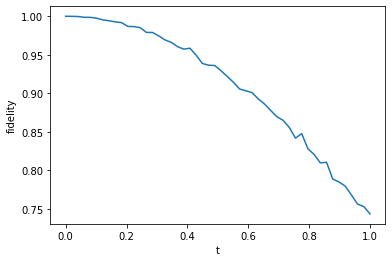

In [30]:
plt.plot(ts, fidelities)
plt.xlabel('t')
plt.ylabel('fidelity')
plt.show()

# 3. Variational Quantum Deflation (VQD)
https://arxiv.org/abs/1805.08138

### 3.1 Classical Baseline

In [31]:
exact_solver = NumPyEigensolver(k=2)
exact_result = exact_solver.compute_eigenvalues(H)
print(exact_result)

{   'aux_operator_eigenvalues': None,
    'eigenstates': ListOp([VectorStateFn(Statevector([-0.25227021+0.04984556j, -0.04984556-0.25227021j,
             -0.42874187+0.00745489j, -0.00745489-0.42874187j,
              0.42268399+0.07220391j, -0.07220391+0.42268399j,
              0.2418314 +0.08742087j, -0.08742087+0.2418314j ],
            dims=(2, 2, 2)), coeff=1.0, is_measurement=False), VectorStateFn(Statevector([ 0.13058298-0.22553789j,  0.22553789+0.13058298j,
             -0.28918099+0.31377556j, -0.31377556-0.28918099j,
             -0.3543427 +0.23774356j, -0.23774356-0.3543427j ,
              0.24286831-0.09452109j,  0.09452109+0.24286831j],
            dims=(2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-9.54591617, -7.6730362 ])}


### 3.2 Define VQD Objective

In [32]:
# set penalty weight for overlap term
penalty = 25

# define objective for VQD
def vqd_objective(param_values, 
                  energy=estimator.estimate, 
                  overlap=lambda x: fidelity.estimate(x, ground_state_params),
                  penalty=penalty):

    value = energy(param_values)
    value += penalty * overlap(param_values)
    return value

### 3.3 Run VQD

In [33]:
# run optimization to get first excited state
result = optimizer.minimize(vqd_objective, np.random.rand(circuit.num_parameters))
print(result)

objective = 3.47216796875
fidelity = 0.0780029296875
objective = 3.8203125
fidelity = 0.099853515625
objective = 3.334716796875
fidelity = 0.068115234375
objective = 3.677978515625
fidelity = 0.1356201171875
objective = 3.198974609375
fidelity = 0.1256103515625
objective = 3.271484375
fidelity = 0.1336669921875
objective = 3.084716796875
fidelity = 0.12060546875
objective = 3.8173828125
fidelity = 0.10791015625
objective = 2.949462890625
fidelity = 0.1251220703125
objective = 3.478759765625
fidelity = 0.0811767578125
objective = 2.177978515625
fidelity = 0.1776123046875
objective = 3.37646484375
fidelity = 0.0579833984375
objective = 4.1435546875
fidelity = 0.0849609375
objective = 2.8388671875
fidelity = 0.1170654296875
objective = 3.999755859375
fidelity = 0.0877685546875
objective = 3.50830078125
fidelity = 0.068603515625
objective = 2.4169921875
fidelity = 0.0736083984375
objective = 3.080322265625
fidelity = 0.123291015625
objective = 3.488037109375
fidelity = 0.0865478515625
obje

objective = -5.232421875
fidelity = 0.00830078125
objective = -5.36767578125
fidelity = 0.0081787109375
objective = -5.263671875
fidelity = 0.0042724609375
objective = -5.31494140625
fidelity = 0.0030517578125
objective = -5.218994140625
fidelity = 0.0166015625
objective = -5.22412109375
fidelity = 0.012451171875
objective = -5.109130859375
fidelity = 0.010009765625
objective = -5.38232421875
fidelity = 0.016845703125
objective = -5.384033203125
fidelity = 0.00048828125
objective = -5.41552734375
fidelity = 0.0
objective = -5.334228515625
fidelity = 0.0108642578125
objective = -5.61083984375
fidelity = 0.0125732421875
objective = -5.47705078125
fidelity = 0.00439453125
objective = -5.37890625
fidelity = 0.000732421875
objective = -5.1572265625
fidelity = 0.0001220703125
objective = -5.6337890625
fidelity = 0.0003662109375
objective = -5.535400390625
fidelity = 0.0003662109375
objective = -5.40380859375
fidelity = 0.0
objective = -5.263427734375
fidelity = 0.017333984375
objective = -5.

In [34]:
# determine energy
estimator.estimate(result.x)

# determine overlap with ground state
fidelity.estimate(result.x, ground_state_params);

objective = -5.990966796875
fidelity = 0.000244140625


### Integrate into Qiskit

Implement Qiskit's `Eigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [35]:
from qiskit.algorithms import Eigensolver, EigensolverResult

class VQD(Eigensolver):
    
    def __init__(self, circuit, optimizer):
        self._circuit = circuit
        self._optimizer = optimizer
        
    def compute_eigenvalues(self, operator, aux_operators=None):
        
        # setup estimators
        estimator = Estimator(operator, self._circuit)
        fidelity = Fidelity(self._circuit, self._circuit)
        
        # compute groundstate
        vqe = CustomVQE(self._circuit, self._optimizer)
        vqe_result = vqe.compute_minimum_eigenvalue(operator)
        
        # compute first excited states
        objective = lambda x: vqd_objective(x, estimator.estimate, 
                                            lambda y: fidelity.estimate(y, vqe_result.optimal_parameters))
        
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(objective, x0)
                
        # populate results
        result = EigensolverResult()
        result.eigenvalues = [vqe_result.eigenvalue, res.fun]        
        return result        

In [36]:
vqd = VQD(circuit, optimizer)
result = vqd.compute_eigenvalues(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'eigenstates': None,
    'eigenvalues': [-6.578369140625, -9.2137451171875]}


# 4. Outlook: Quantum Computational Primitives

- We will move towards quantum computational primitives, powered by Qiskit Runtime, e.g., for sampling, estimation, etc.
- These will encapsulate error mitigation and other features to improve the ease of use.
- The complete Qiskit Algorithms & Applications stack will be extended accordingly over 2022.